<a href="https://colab.research.google.com/github/20KMJ/ESAA7/blob/main/%EC%BA%90%EA%B8%80%ED%95%84%EC%82%AC_%EC%9D%98%EB%A5%98%EC%9D%B4%EB%AF%B8%EC%A7%80%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 기본 분류: 의류 이미지 분류

운동화나 셔츠 같은 옷 이미지를 분류하는 신경망 모델 훈련하기

텐서플로 모델을 만들고 훈련할 수 있는 고수준 API인 tf.keras를 사용함

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.12.0


## 1. 패션 MNIST 데이터셋 임포트하기

10개의 범주(category)와 70,000개의 흑백 이미지로 구성된 패션 MNIST 데이터셋을 사용함

 60,000개의 이미지를 사용하여 네트워크를 훈련하고 10,000개의 이미지를 사용하여 네트워크에서 이미지 분류를 학습한 정도를 평가

 TensorFlow에서 직접 Fashion MNIST 데이터를 가져오고 로드

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


load_data() 함수를 호출하면 네 개의 넘파이(NumPy) 배열이 반환됨

레이블(label)은 0에서 9까지의 정수 배열임. 이 값은 이미지에 있는 옷의 클래스(class)를 나타냄.

- 레이블:	클래스
- 0:	T-shirt/top
- 1:	Trouser
- 2:	Pullover
- 3:	Dress
- 4:	Coat
- 5:	Sandal
- 6:	Shirt
- 7:	Sneaker
- 8:	Bag
- 9:	Ankle boot

In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## 2. 데이터 탐색

모델을 훈련하기 전에 데이터셋 구조 살펴보기

훈련 세트에는 60,000개의 레이블 존재. 각 레이블은 0과 9사이의 정수임

In [4]:
train_images.shape

(60000, 28, 28)

In [5]:
len(train_labels)

60000

In [6]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

테스트 세트에는 10,000개의 이미지가 있음.

In [7]:
test_images.shape

(10000, 28, 28)

In [8]:
len(test_labels)

10000

## 3. 데이터 전처리

픽셀 값의 범위가 0 ~ 255 사이. 신경망 모델에 주입하기 전에 이 값의 범위를 0 ~ 1 사이로 조정하기.

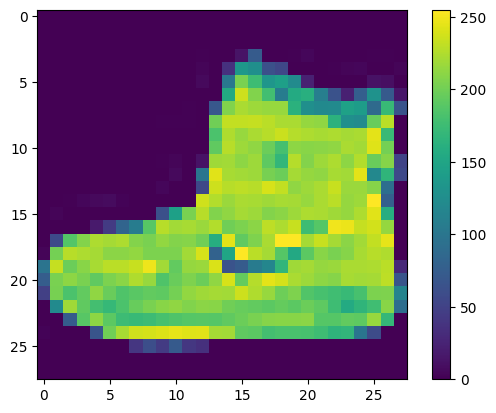

In [9]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [10]:
# 범위 0 ~ 1로. 훈련 및 테스트 세트에 동일하기 적용하기
train_images = train_images / 255.0
test_images = test_images / 255.0

> 훈련 세트에서 처음 25개 이미지와 그 아래 클래스 이름을 출력해보자

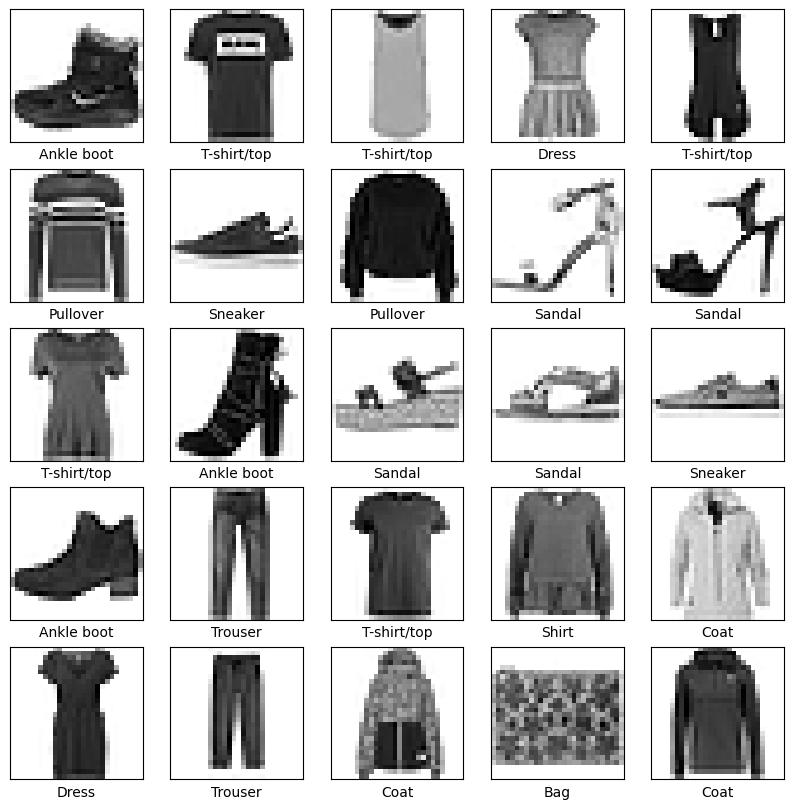

In [11]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

## 4. 모델 구성

신경망 모델을 만들려면 모델의 층을 구성한 다음 모델을 컴파일한다.

### 4.1 층 설정

신경망의 기본 빌딩 블록은 레이어.

대부분 딥러닝은 간단한 층을 연결하여 구성됨. tf.keras.layers.Dense와 같은 층들의 가중치(parameter)는 훈련하는 동안 학습됨.

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])

Flatten을 사용하여 2차원 배열의 이미지 포맷을 펼쳐 1차원 배열로 변환.

픽셀을 펼친 후에는 두 개의 tf.keras.layers.Dense 층이 연속되어 연결됨. 이 층을 **밀집 연결(densely-connected)** 또는 **완전 연결(fully-connected) 층**이라고 부름.

첫 번째 Dense 층은 128개의 노드(또는 뉴런)을 가짐

두 번째(마지막) 층은 10개의 노드의 소프트맥스(softmax) 층임. 이 층은 10개의 확률을 반환하고 반환된 값의 전체 합은 1임. 각 노드는 현재 이미지가 10개 클래스 중 하나에 속할 확률을 출력함.

### 4.2 모델 컴파일

- **손실 함수**: 훈련 중 모델이 얼마나 정확한지 측정. 모델을 올바른 방향으로 조정하려면 이 함수를 최소화해야함.
- **옵티마이저**: 모델이 인식하는 데이터와 해당 손실 함수를 기반으로 모델이 업데이트되는 방식
- **메트릭**: 훈련 및 테스트 단계를 모니터링하는 데 사용. 다음 예에서는 올바르게 분류된 이미지의 비율인 정확도를 사용함

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## 5. 모델 훈련

1. 훈련 데이터를 모델에 주입한다. (train_images와 train_labels 배열)
2. 모델이 이미지와 레이블을 매핑하는 방법을 배운다.
3. 테스트 세트에 대한 모델의 예측을 만든다. (test_images 배열)
4. 예측이 test_labels 배열의 레이블과 일치하는지 확인한다.

### 5.1 모델 피드

In [14]:
model.fit(train_images, train_labels, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.5010 - accuracy: 0.8235
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3754 - accuracy: 0.8635
Epoch 3/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.3359 - accuracy: 0.8781
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3145 - accuracy: 0.8831
Epoch 5/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2978 - accuracy: 0.8903
Epoch 6/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2831 - accuracy: 0.8959
Epoch 7/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2688 - accuracy: 0.8990
Epoch 8/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2582 - accuracy: 0.9037
Epoch 9/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2478 - accuracy: 0.9074
Epoch 10/10
1875/1875 [==============================] - 14s 7ms/step - loss

모델이 훈련되면서 손실과 정확도 지표가 출력됨. 이 모델은 훈련 세트에서 약 0.88(88%) 정도의 정확도를 달성함.

### 5.2 정확도 평가

In [15]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 1s - loss: 0.3619 - accuracy: 0.8766 - 652ms/epoch - 2ms/step

Test accuracy: 0.8766000270843506


테스트 세트의 정확도가 훈련 세트의 정확도보다 조금 낮음. 훈련 세트의 정확도와 테스트 세트의 정확도 사이의 차이는 과대적합(overfitting) 때문

### 5.3 예측하기

In [16]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])
predictions = probability_model.predict(test_images)

313/313 [==============================] - 2s 6ms/step


In [17]:
# 첫 번째 예
predictions[0]

array([4.5741428e-09, 1.5545641e-10, 2.8845895e-09, 6.8042953e-09,
       2.4689537e-09, 7.8391697e-04, 1.0283306e-08, 4.1652899e-02,
       1.0890605e-08, 9.5756316e-01], dtype=float32)

In [18]:
np.argmax(predictions[0])

9

모델은 이 이미지가 앵클 부츠(class_name[9])라고 가장 확신하고 있음. 이 값이 맞는지 테스트 레이블을 확인해보자:

In [19]:
test_labels[0]

9

10개 클래스에 대한 예측을 모두 그래프로 표현하기 위한 함수를 생성하자.

In [20]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

### 5.4 예측 확인

0번째 원소의 이미지, 예측, 신뢰도 점수 배열을 확인해보자.

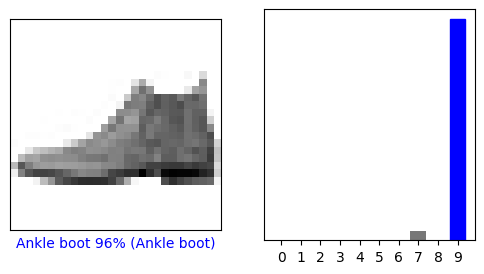

In [21]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

12번째 원소의 이미지, 예측, 신뢰도 점수 배열을 확인해보자.

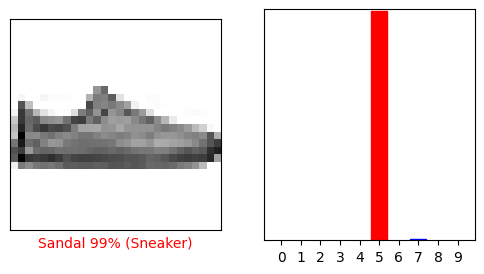

In [23]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

몇 개의 이미지 예측을 출력해보자.

파란색: 올바르게 예측된 레이블

빨간색: 잘못 예측된 레이블

숫자는 예측 레이블의 신뢰도 퍼센트(100점 만점)이다. 신뢰도 점수가 높을 때도 잘못 예측할 수 있다.

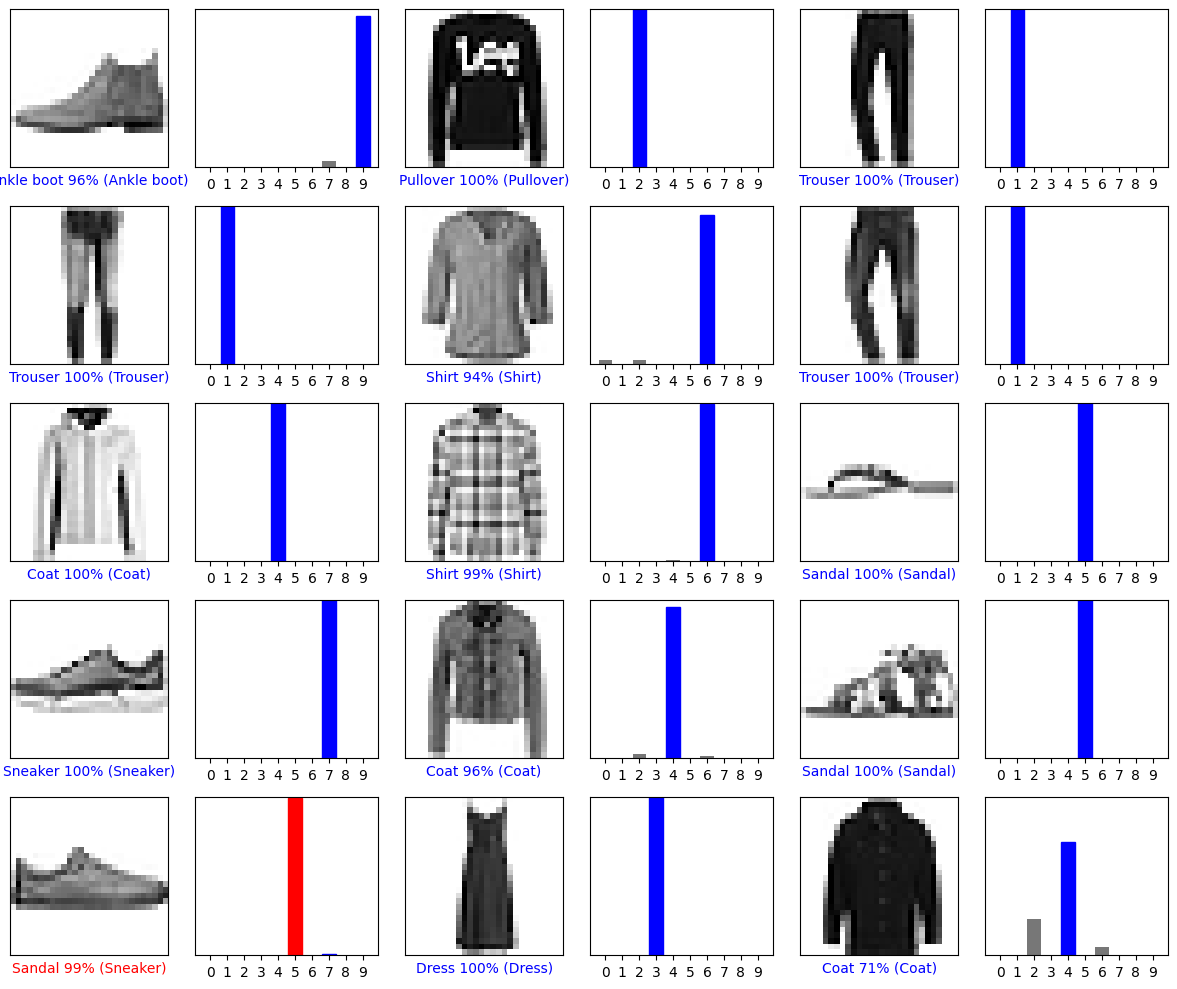

In [24]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

## 6. 훈련된 모델 사용하기

훈련된 모델을 사용하여 한 이미지에 대한 예측을 만들자.

In [25]:
# Grab an image from the test dataset.
img = test_images[1]

print(img.shape)

(28, 28)


tf.keras 모델은 한 번에 샘플의 묶음 또는 배치(batch)로 예측을 만드는데 최적화되어 있습니다. 하나의 이미지를 사용할 때에도 2차원 배열로 만들어야 한다.

In [26]:
# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

print(img.shape)

(1, 28, 28)


이미지의 예측을 만들자.

In [27]:
predictions_single = probability_model.predict(img)

print(predictions_single)

1/1 [==============================] - 0s 26ms/step
[[1.0885659e-05 8.1255585e-19 9.9888295e-01 5.3025622e-11 5.5515644e-04
  6.5532019e-18 5.5096863e-04 2.1569010e-16 1.2828849e-11 4.6348574e-19]]


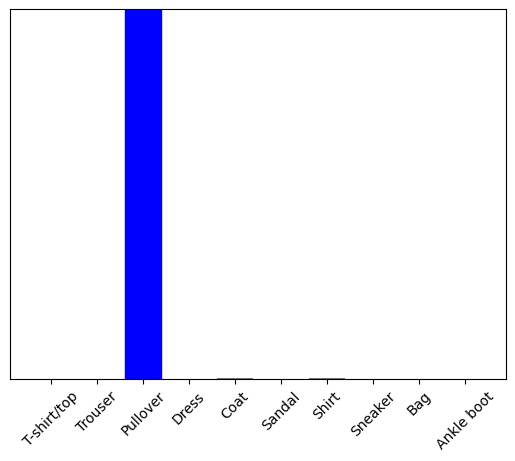

In [28]:
plot_value_array(1, predictions_single[0], test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)
plt.show()

In [29]:
np.argmax(predictions_single[0])

2